In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboost"
device = "cpu"
min_samples_per_class = 5
n_classes = 34
n_frac = 0.05
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Backdoor_Malware': 28,
    'BenignTraffic': 12,
    'BrowserHijacking': 29,
    'CommandInjection': 25,
    'DDoS-ACK_Fragmentation': 14,
    'DDoS-HTTP_Flood': 23,
    'DDoS-ICMP_Flood': 2,
    'DDoS-ICMP_Fragmentation': 17,
    'DDoS-PSHACK_Flood': 9,
    'DDoS-RSTFINFlood': 0,
    'DDoS-SYN_Flood': 8,
    'DDoS-SlowLoris': 27,
    'DDoS-SynonymousIP_Flood': 6,
    'DDoS-TCP_Flood': 10,
    'DDoS-UDP_Flood': 11,
    'DDoS-UDP_Fragmentation': 20,
    'DNS_Spoofing': 19,
    'DictionaryBruteForce': 30,
    'DoS-HTTP_Flood': 16,
    'DoS-SYN_Flood': 4,
    'DoS-TCP_Flood': 1,
    'DoS-UDP_Flood': 3,
    'MITM-ArpSpoofing': 13,
    'Mirai-greeth_flood': 5,
    'Mirai-greip_flood': 15,
    'Mirai-udpplain': 7,
    'Recon-HostDiscovery': 24,
    'Recon-OSScan': 21,
    'Recon-PingSweep': 32,
    'Recon-PortScan': 18,
    'SqlInjection': 31,
    'Uploading_Attack': 33,
    'VulnerabilityScan': 26,
    'XSS': 22}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
2     359651
11    270509
10    224944
9     204524
8     202766
0     202569
6     179626
3     165461
1     133859
4     101355
12     54907
5      49814
7      44645
15     37673
17     22740
13     15515
20     14336
14     14311
19      8886
24      6838
21      5004
18      4219
16      3710
26      1839
23      1459
27      1201
30       625
29       298
25       271
31       239
22       179
28       167
32       118
33        71
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_2433815/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
2     360025
11    270614
10    224883
9     204737
8     202959
0     202264
6     179906
3     165929
1     133572
4     101441
12     54909
5      49593
7      44528
15     37584
17     22624
13     15379
20     14346
14     14255
19      8945
24      6718
21      4912
18      4114
16      3593
26      1869
23      1439
27      1171
30       653
29       292
25       270
31       262
22       192
28       160
32       113
33        62
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(2334313, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(2334313,)
int64
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
34


label
2     360025
11    270614
10    224883
9     204737
8     202959
0     202264
6     179906
3     165929
1     133572
4     101441
12     54909
5      49593
7      44528
15     37584
17     22624
13     15379
20     14346
14     14255
19      8945
24      6718
21      4912
18      4114
16      3593
26      1869
23      1439
27      1171
30       653
29       292
25       270
31       262
22       192
28       160
32       113
33        62
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 1400587	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Validation : 466863	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 466863	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-13 18:48:58,228] A new study created in memory with name: no-name-7e5716bb-6773-4b6c-942f-069d8e097e3a


[I 2024-07-13 18:54:49,086] Trial 0 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-13 19:53:54,829] Trial 1 finished with value: 0.7585048007941744 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.7585048007941744.


[I 2024-07-13 20:00:03,331] Trial 2 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-13 20:05:59,619] Trial 3 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-13 20:15:51,184] Trial 4 pruned. 


index 28 is out of bounds for axis 0 with size 12


[I 2024-07-13 20:47:19,751] Trial 5 finished with value: 0.7530871591163413 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.7585048007941744.


[I 2024-07-13 21:05:13,620] Trial 6 finished with value: 0.7532397761793465 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 1 with value: 0.7585048007941744.


[I 2024-07-13 21:11:00,430] Trial 7 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-13 21:21:18,729] Trial 8 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-13 21:31:00,412] Trial 9 pruned. 


index 19 is out of bounds for axis 0 with size 12


[I 2024-07-13 22:03:55,939] Trial 10 finished with value: 0.7952071687936975 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7952071687936975.


[I 2024-07-13 23:02:57,062] Trial 11 finished with value: 0.7556500037514147 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7952071687936975.


[I 2024-07-13 23:12:42,829] Trial 12 pruned. 


index 29 is out of bounds for axis 0 with size 12


[I 2024-07-13 23:18:33,202] Trial 13 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-13 23:49:47,462] Trial 14 finished with value: 0.7543013167028144 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7952071687936975.


[I 2024-07-13 23:55:43,110] Trial 15 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-14 00:06:39,071] Trial 16 finished with value: 0.7550833725987465 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7952071687936975.


[I 2024-07-14 00:17:01,249] Trial 17 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-14 01:16:12,800] Trial 18 finished with value: 0.7581790153431158 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7952071687936975.


[I 2024-07-14 01:47:31,826] Trial 19 finished with value: 0.7530871591163413 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7952071687936975.


[I 2024-07-14 01:58:35,736] Trial 20 pruned. 


index 27 is out of bounds for axis 0 with size 12


[I 2024-07-14 02:15:04,294] Trial 21 finished with value: 0.7994224041969791 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 03:14:21,484] Trial 22 finished with value: 0.7558331133614957 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 03:24:53,701] Trial 23 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-14 04:26:54,923] Trial 24 finished with value: 0.7896606855837396 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 04:37:35,995] Trial 25 finished with value: 0.7514263214958632 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 05:09:31,667] Trial 26 finished with value: 0.7530871591163413 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 05:18:58,908] Trial 27 pruned. 


index 29 is out of bounds for axis 0 with size 12


[I 2024-07-14 05:36:45,061] Trial 28 finished with value: 0.7532397761793465 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 05:46:51,947] Trial 29 pruned. 


index 22 is out of bounds for axis 0 with size 12


[I 2024-07-14 05:57:12,064] Trial 30 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-14 06:06:52,100] Trial 31 pruned. 


index 29 is out of bounds for axis 0 with size 12


[I 2024-07-14 06:17:19,713] Trial 32 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-14 06:31:43,724] Trial 33 finished with value: 0.7509250797804733 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 07:03:16,518] Trial 34 finished with value: 0.7577906977109687 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


[I 2024-07-14 08:02:42,813] Trial 35 finished with value: 0.7556500037514147 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 21 with value: 0.7994224041969791.


CPU times: user 34d 1h 6min 1s, sys: 13min 44s, total: 34d 1h 19min 46s
Wall time: 13h 13min 44s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0       NaN 2024-07-13 18:48:58.229454 2024-07-13 18:54:49.086047   
1        1  0.758505 2024-07-13 18:54:49.086766 2024-07-13 19:53:54.828965   
2        2       NaN 2024-07-13 19:53:54.830008 2024-07-13 20:00:03.331812   
3        3       NaN 2024-07-13 20:00:03.332742 2024-07-13 20:05:59.619836   
4        4       NaN 2024-07-13 20:05:59.620722 2024-07-13 20:15:51.184497   
5        5  0.753087 2024-07-13 20:15:51.185298 2024-07-13 20:47:19.751203   
6        6  0.753240 2024-07-13 20:47:19.752210 2024-07-13 21:05:13.619839   
7        7       NaN 2024-07-13 21:05:13.620801 2024-07-13 21:11:00.429947   
8        8       NaN 2024-07-13 21:11:00.430673 2024-07-13 21:21:18.729174   
9        9       NaN 2024-07-13 21:21:18.730071 2024-07-13 21:31:00.412538   
10      10  0.795207 2024-07-13 21:31:00.413434 2024-07-13 22:03:55.939738   
11      11  0.755650 2024-07-13 22:03:55.940784 2024-07-13 23:02:57.061926   
12      12       NaN 2024-07-13 23:02:57.062860 2024-07-13 23:12:42.829860   
13      13       NaN 2024-07-13 23:12:42.830762 2024-07-13 23:18:33.202753   
14      14  0.754301 2024-07-13 23:18:33.203695 2024-07-13 23:49:47.461989   
15      15       NaN 2024-07-13 23:49:47.463016 2024-07-13 23:55:43.110379   
16      16  0.755083 2024-07-13 23:55:43.111119 2024-07-14 00:06:39.071087   
17      17       NaN 2024-07-14 00:06:39.071913 2024-07-14 00:17:01.249411   
18      18  0.758179 2024-07-14 00:17:01.250319 2024-07-14 01:16:12.800306   
19      19  0.753087 2024-07-14 01:16:12.801327 2024-07-14 01:47:31.826594   
20      20       NaN 2024-07-14 01:47:31.827431 2024-07-14 01:58:35.736247   
21      21  0.799422 2024-07-14 01:58:35.737134 2024-07-14 02:15:04.294045   
22      22  0.755833 2024-07-14 02:15:04.294865 2024-07-14 03:14:21.484711   
23      23       NaN 2024-07-14 03:14:21.485551 2024-07-14 03:24:53.701854   
24      24  0.789661 2024-07-14 03:24:53.702737 2024-07-14 04:26:54.923348   
25      25  0.751426 2024-07-14 04:26:54.924390 2024-07-14 04:37:35.995271   
26      26  0.753087 2024-07-14 04:37:35.996325 2024-07-14 05:09:31.666961   
27      27       NaN 2024-07-14 05:09:31.667882 2024-07-14 05:18:58.908337   
28      28  0.753240 2024-07-14 05:18:58.908953 2024-07-14 05:36:45.060926   
29      29       NaN 2024-07-14 05:36:45.061776 2024-07-14 05:46:51.947395   
30      30       NaN 2024-07-14 05:46:51.948302 2024-07-14 05:57:12.064056   
31      31       NaN 2024-07-14 05:57:12.064678 2024-07-14 06:06:52.100700   
32      32       NaN 2024-07-14 06:06:52.101449 2024-07-14 06:17:19.712996   
33      33  0.750925 2024-07-14 06:17:19.713799 2024-07-14 06:31:43.724736   
34      34  0.757791 2024-07-14 06:31:43.725575 2024-07-14 07:03:16.517868   
35      35  0.755650 2024-07-14 07:03:16.518716 2024-07-14 08:02:42.813426   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:05:50.856593           boruta     shap_importances   
1  0 days 00:59:05.742199              rfa  feature_importances   
2  0 days 00:06:08.501804           boruta     shap_importances   
3  0 days 00:05:56.287094           boruta     shap_importances   
4  0 days 00:09:51.563775              rfe     shap_importances   
5  0 days 00:31:28.565905              rfe  feature_importances   
6  0 days 00:17:53.867629           boruta  feature_importances   
7  0 days 00:05:46.809146           boruta     shap_importances   
8  0 days 00:10:18.298501              rfa     shap_importances   
9  0 days 00:09:41.682467              rfe     shap_importances   
10 0 days 00:32:55.526304              rfe  feature_importances   
11 0 days 00:59:01.121142              rfa  feature_importances   
12 0 days 00:09:45.767000              rfe     shap_importances   
13 0 days 00:05:50.371991           boruta     shap_importances   
14 0 days 00:31:14.258294              rfe  feature_importances   
15 0 days 00:05:55.647363           boruta   

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-14 08:02:43,831] Param fs_metric unique value length is less than 2.


[W 2024-07-14 08:02:43,832] Param fs_metric unique value length is less than 2.


[W 2024-07-14 08:02:43,832] Param fs_metric unique value length is less than 2.


[W 2024-07-14 08:02:43,832] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-14 08:02:45,239] A new study created in memory with name: no-name-8cf2b76e-470f-48cf-b555-0af36a013c6b


[I 2024-07-14 08:03:47,381] Trial 0 finished with value: 0.8435947737398006 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:04:31,111] Trial 1 finished with value: 0.8029789039248573 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:05:07,611] Trial 2 finished with value: 0.8121762407102799 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:05:45,390] Trial 3 finished with value: 0.8185915380182871 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:06:33,619] Trial 4 finished with value: 0.8034402691240273 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:07:22,046] Trial 5 finished with value: 0.8139442128700158 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:08:01,450] Trial 6 finished with value: 0.8000854830704629 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:08:37,005] Trial 7 finished with value: 0.79770384056721 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:09:24,061] Trial 8 finished with value: 0.8163145294183501 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:09:56,827] Trial 9 finished with value: 0.8160560133997213 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 0 with value: 0.8435947737398006.


[I 2024-07-14 08:10:55,776] Trial 10 finished with value: 0.8493155877481918 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:11:28,488] Trial 11 finished with value: 0.8145119418668352 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:12:01,747] Trial 12 finished with value: 0.7971000777545589 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:12:34,504] Trial 13 finished with value: 0.8124069366611697 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:13:26,552] Trial 14 finished with value: 0.8086843617248471 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:14:03,873] Trial 15 finished with value: 0.8330303545424371 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:14:54,700] Trial 16 finished with value: 0.8019496192918742 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:15:46,871] Trial 17 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:16:14,873] Trial 18 finished with value: 0.7996906988470938 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:16:45,323] Trial 19 finished with value: 0.8152583363539534 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:17:25,900] Trial 20 finished with value: 0.8209145155870915 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:17:58,816] Trial 21 finished with value: 0.8188152411995386 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:18:33,276] Trial 22 finished with value: 0.8051595808422167 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:19:37,940] Trial 23 finished with value: 0.8468761483011622 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:20:12,551] Trial 24 finished with value: 0.8207703146471318 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:20:45,815] Trial 25 finished with value: 0.8118666788155634 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:21:19,725] Trial 26 finished with value: 0.8245597410086453 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:22:02,262] Trial 27 finished with value: 0.8021050425870423 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:22:38,203] Trial 28 finished with value: 0.8233888913701385 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:23:07,842] Trial 29 finished with value: 0.8312955035798368 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:23:38,153] Trial 30 finished with value: 0.7991492493981919 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:24:10,212] Trial 31 finished with value: 0.8386154101762981 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:24:42,352] Trial 32 finished with value: 0.8043532541405828 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:25:30,532] Trial 33 finished with value: 0.8055760358781866 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:26:14,181] Trial 34 finished with value: 0.7932620231418551 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:26:48,727] Trial 35 finished with value: 0.8157027991106245 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:27:22,994] Trial 36 finished with value: 0.8146316027843842 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:28:07,477] Trial 37 finished with value: 0.8180583716176927 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:28:42,516] Trial 38 finished with value: 0.8063508508329883 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:29:16,195] Trial 39 finished with value: 0.8124069366611697 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:29:48,685] Trial 40 finished with value: 0.8163854461115858 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:30:23,338] Trial 41 finished with value: 0.801805053546943 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:31:02,341] Trial 42 finished with value: 0.8160229657108491 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:31:35,577] Trial 43 finished with value: 0.8194592196791524 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:32:29,262] Trial 44 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:33:11,019] Trial 45 finished with value: 0.8101565617024657 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:33:48,920] Trial 46 finished with value: 0.818251516774079 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:34:20,966] Trial 47 finished with value: 0.8015958969543089 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:35:00,831] Trial 48 finished with value: 0.8199426925213436 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:35:46,168] Trial 49 finished with value: 0.8090893417740751 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:36:20,265] Trial 50 finished with value: 0.8245597410086453 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:36:50,470] Trial 51 finished with value: 0.8059746375572615 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:37:30,335] Trial 52 finished with value: 0.8323075997702404 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:38:04,609] Trial 53 finished with value: 0.8245597410086453 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:38:38,960] Trial 54 finished with value: 0.8237494437782076 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:39:32,596] Trial 55 finished with value: 0.8478364855179371 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:40:07,034] Trial 56 finished with value: 0.7961391978459545 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:40:32,744] Trial 57 finished with value: 0.8044936669456214 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:41:25,460] Trial 58 finished with value: 0.8134205619366629 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:42:13,627] Trial 59 finished with value: 0.8153914437243825 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:42:58,345] Trial 60 finished with value: 0.8208724506979911 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:43:44,510] Trial 61 finished with value: 0.8075955767072136 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:44:14,119] Trial 62 finished with value: 0.8031907525557826 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:44:56,294] Trial 63 finished with value: 0.8098362399340658 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:45:28,112] Trial 64 finished with value: 0.80961834433625 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:46:05,392] Trial 65 finished with value: 0.8082278681577519 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:47:10,567] Trial 66 finished with value: 0.8398956336469886 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:48:00,458] Trial 67 finished with value: 0.7984813313811148 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:48:33,573] Trial 68 finished with value: 0.8172192494427891 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:49:11,038] Trial 69 finished with value: 0.7933069964412053 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:49:53,194] Trial 70 finished with value: 0.8083021106488596 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:50:31,011] Trial 71 finished with value: 0.8147528104500417 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:51:01,703] Trial 72 finished with value: 0.8142854508454083 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:51:32,939] Trial 73 finished with value: 0.8153560709767639 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:52:19,792] Trial 74 finished with value: 0.7957620287506832 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:52:51,071] Trial 75 finished with value: 0.8139004480599741 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:53:21,394] Trial 76 finished with value: 0.7991492493981919 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:53:56,222] Trial 77 finished with value: 0.8031314168285185 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:54:26,638] Trial 78 finished with value: 0.8142854508454083 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:54:57,246] Trial 79 finished with value: 0.8037346610427923 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:55:35,112] Trial 80 finished with value: 0.8219664506352801 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:56:13,396] Trial 81 finished with value: 0.8200226874595474 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:57:02,349] Trial 82 finished with value: 0.8059572138369359 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:57:35,578] Trial 83 finished with value: 0.8262302597675941 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:58:06,711] Trial 84 finished with value: 0.8148405138454138 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:58:46,279] Trial 85 finished with value: 0.8082310773129309 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 08:59:19,276] Trial 86 finished with value: 0.8309969308071552 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:00:04,600] Trial 87 finished with value: 0.8153779290113575 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:00:57,093] Trial 88 finished with value: 0.8059596928540784 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:01:49,142] Trial 89 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:02:22,085] Trial 90 finished with value: 0.8174560876915009 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:02:55,008] Trial 91 finished with value: 0.8124069366611697 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:03:47,724] Trial 92 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:04:39,632] Trial 93 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:05:22,338] Trial 94 finished with value: 0.8172818686290185 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:05:50,704] Trial 95 finished with value: 0.8118454002538497 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:06:29,768] Trial 96 finished with value: 0.792768251458893 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:07:07,683] Trial 97 finished with value: 0.799689472449053 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:08:01,123] Trial 98 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:08:46,717] Trial 99 finished with value: 0.8172392116720401 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:09:16,784] Trial 100 finished with value: 0.7989582826818279 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:09:58,414] Trial 101 finished with value: 0.8146316027843842 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:10:38,938] Trial 102 finished with value: 0.7918291426280517 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:11:11,760] Trial 103 finished with value: 0.8159493851808497 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:11:45,769] Trial 104 finished with value: 0.817840913823915 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:12:33,376] Trial 105 finished with value: 0.796279581066367 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:13:06,750] Trial 106 finished with value: 0.8262302597675941 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:13:40,068] Trial 107 finished with value: 0.820384841780086 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:14:27,817] Trial 108 finished with value: 0.8091812023513548 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:15:02,826] Trial 109 finished with value: 0.827007285235413 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:15:44,012] Trial 110 finished with value: 0.8046175619683403 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:16:14,617] Trial 111 finished with value: 0.7991492493981919 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:16:44,004] Trial 112 finished with value: 0.8038059321465151 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:17:30,184] Trial 113 finished with value: 0.804179889496802 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:18:03,139] Trial 114 finished with value: 0.806022637375336 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:18:34,815] Trial 115 finished with value: 0.8203663432226794 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:19:07,965] Trial 116 finished with value: 0.823428410651865 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:19:52,308] Trial 117 finished with value: 0.8099791492427737 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:20:17,730] Trial 118 finished with value: 0.8054979868883961 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:21:06,626] Trial 119 finished with value: 0.8113779073452139 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:21:38,644] Trial 120 finished with value: 0.8047453168381734 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:22:13,513] Trial 121 finished with value: 0.8091662520658511 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:22:50,454] Trial 122 finished with value: 0.8086650429910176 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:23:23,313] Trial 123 finished with value: 0.8166497101166201 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:23:59,227] Trial 124 finished with value: 0.79531778219215 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:24:32,931] Trial 125 finished with value: 0.8081698261425684 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:25:21,111] Trial 126 finished with value: 0.8231895568765395 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:25:47,275] Trial 127 finished with value: 0.7953326847532937 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:26:34,633] Trial 128 finished with value: 0.8000400170922017 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:27:21,750] Trial 129 finished with value: 0.8152631911260694 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:27:54,631] Trial 130 finished with value: 0.823428410651865 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:28:34,532] Trial 131 finished with value: 0.8196630533427126 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:29:18,572] Trial 132 finished with value: 0.8111569072948437 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:29:56,217] Trial 133 finished with value: 0.8038016751437221 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:30:26,388] Trial 134 finished with value: 0.8041708864143916 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:30:58,030] Trial 135 finished with value: 0.8063535143355528 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:31:30,257] Trial 136 finished with value: 0.823428410651865 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:32:04,579] Trial 137 finished with value: 0.8166497101166201 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:32:44,674] Trial 138 finished with value: 0.8004124879670802 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:33:29,059] Trial 139 finished with value: 0.814897078004383 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:33:58,372] Trial 140 finished with value: 0.8046851437050022 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:34:29,293] Trial 141 finished with value: 0.8152154826700215 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:35:07,763] Trial 142 finished with value: 0.8230708611626142 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:35:55,192] Trial 143 finished with value: 0.808115285285001 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:36:43,731] Trial 144 finished with value: 0.8040824185823174 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:37:22,665] Trial 145 finished with value: 0.8136640425488613 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:38:04,449] Trial 146 finished with value: 0.8165044248125602 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:38:40,563] Trial 147 finished with value: 0.8118507546389268 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:39:18,119] Trial 148 finished with value: 0.8165478328262433 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:39:52,249] Trial 149 finished with value: 0.8146316027843842 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:40:38,027] Trial 150 finished with value: 0.7966567723350947 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:41:13,052] Trial 151 finished with value: 0.8121802472028457 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:41:58,192] Trial 152 finished with value: 0.7969068306788601 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:42:28,313] Trial 153 finished with value: 0.8079400577249392 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:43:04,148] Trial 154 finished with value: 0.8117325343887724 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:43:47,642] Trial 155 finished with value: 0.8095184901683377 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:44:23,566] Trial 156 finished with value: 0.8219266517011447 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:45:00,242] Trial 157 finished with value: 0.8099892763025373 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:45:32,403] Trial 158 finished with value: 0.8221236406513881 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:46:20,039] Trial 159 finished with value: 0.8233836279257806 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:47:06,760] Trial 160 finished with value: 0.8093941100005778 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:47:46,609] Trial 161 finished with value: 0.8066277499731108 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:48:17,055] Trial 162 finished with value: 0.8142854508454083 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:48:55,344] Trial 163 finished with value: 0.7946380083036768 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:49:25,096] Trial 164 finished with value: 0.8126098485802208 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:50:04,033] Trial 165 finished with value: 0.8080737894116568 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:50:38,132] Trial 166 finished with value: 0.8003594707961126 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:51:11,856] Trial 167 finished with value: 0.8185848425336196 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:51:51,652] Trial 168 finished with value: 0.8001096428092862 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:52:26,379] Trial 169 finished with value: 0.822844985882119 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:53:11,287] Trial 170 finished with value: 0.8027109677906621 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:53:41,113] Trial 171 finished with value: 0.8142854508454083 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:54:10,258] Trial 172 finished with value: 0.8055529179539072 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:54:53,700] Trial 173 finished with value: 0.7949473577411983 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:55:24,312] Trial 174 finished with value: 0.814994500177499 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:56:03,018] Trial 175 finished with value: 0.8287087465363078 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:56:39,137] Trial 176 finished with value: 0.8082444102470466 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:57:18,508] Trial 177 finished with value: 0.812272580062235 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:57:52,985] Trial 178 finished with value: 0.8245597410086453 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:58:21,793] Trial 179 finished with value: 0.7994634815737509 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:59:06,859] Trial 180 finished with value: 0.7994224041969791 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 09:59:44,827] Trial 181 finished with value: 0.8138458920898453 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:00:30,217] Trial 182 finished with value: 0.8267617132142799 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:01:13,037] Trial 183 finished with value: 0.8118580715573255 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:01:49,346] Trial 184 finished with value: 0.8063209460319879 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:02:29,497] Trial 185 finished with value: 0.7983512663440593 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:03:02,803] Trial 186 finished with value: 0.8106142362364096 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:03:37,691] Trial 187 finished with value: 0.8201911884722527 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:04:15,880] Trial 188 finished with value: 0.7876936392715329 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:05:03,752] Trial 189 finished with value: 0.8087190656952536 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:05:35,030] Trial 190 finished with value: 0.8148405138454138 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:06:07,571] Trial 191 finished with value: 0.8174560876915009 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:06:41,721] Trial 192 finished with value: 0.8146316027843842 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:07:27,064] Trial 193 finished with value: 0.8067071794547894 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:08:19,640] Trial 194 finished with value: 0.8492956493154704 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:08:52,050] Trial 195 finished with value: 0.8174560876915009 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:09:25,096] Trial 196 finished with value: 0.7928755662097655 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:10:01,927] Trial 197 finished with value: 0.8170225150163852 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:10:35,020] Trial 198 finished with value: 0.8207163319095193 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:11:19,617] Trial 199 finished with value: 0.7947250174867253 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:11:53,719] Trial 200 finished with value: 0.8281523785326756 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:12:27,770] Trial 201 finished with value: 0.8155205269992146 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:13:04,882] Trial 202 finished with value: 0.7904079757698853 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:13:43,774] Trial 203 finished with value: 0.8192816800626516 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:14:17,540] Trial 204 finished with value: 0.8172192494427891 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:14:50,508] Trial 205 finished with value: 0.8108071178996987 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:15:24,156] Trial 206 finished with value: 0.8262302597675941 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:15:55,725] Trial 207 finished with value: 0.8063535143355528 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:16:31,297] Trial 208 finished with value: 0.8103971340673588 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:17:04,874] Trial 209 finished with value: 0.8182258975685275 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:17:49,434] Trial 210 finished with value: 0.8013453917096325 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:18:18,937] Trial 211 finished with value: 0.8101970987786431 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:19:09,039] Trial 212 finished with value: 0.8088266225319805 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:19:37,917] Trial 213 finished with value: 0.8031907525557826 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:20:10,810] Trial 214 finished with value: 0.8227794563215293 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:20:52,516] Trial 215 finished with value: 0.8304272824573795 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:21:25,163] Trial 216 finished with value: 0.8063535143355528 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:21:58,571] Trial 217 finished with value: 0.8166497101166201 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:23:03,145] Trial 218 finished with value: 0.8430033722699385 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:23:41,973] Trial 219 finished with value: 0.8237955559617871 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:24:29,487] Trial 220 finished with value: 0.8051478474768048 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:25:04,762] Trial 221 finished with value: 0.817620406564967 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:25:35,873] Trial 222 finished with value: 0.8148405138454138 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:26:09,430] Trial 223 finished with value: 0.8166497101166201 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:26:52,331] Trial 224 finished with value: 0.82441556573251 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:27:25,790] Trial 225 finished with value: 0.8172192494427891 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:27:59,983] Trial 226 finished with value: 0.8136178429447064 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:28:46,168] Trial 227 finished with value: 0.8201900464367877 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:29:19,394] Trial 228 finished with value: 0.8175742067916768 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:30:17,583] Trial 229 finished with value: 0.8446027488829905 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:30:48,304] Trial 230 finished with value: 0.7991492493981919 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:31:17,938] Trial 231 finished with value: 0.8031907525557826 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:31:54,487] Trial 232 finished with value: 0.8153548837192762 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:32:27,888] Trial 233 finished with value: 0.811048385668612 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:32:56,256] Trial 234 finished with value: 0.7996906988470938 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:33:34,255] Trial 235 finished with value: 0.816991420428848 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:34:17,331] Trial 236 finished with value: 0.813573062968149 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:34:57,200] Trial 237 finished with value: 0.8054862910988546 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:35:42,693] Trial 238 finished with value: 0.8198843276179743 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:36:22,562] Trial 239 finished with value: 0.8135601830242813 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:37:06,132] Trial 240 finished with value: 0.7954027261550101 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:37:59,273] Trial 241 finished with value: 0.8444331557792649 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:38:27,457] Trial 242 finished with value: 0.7996906988470938 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:39:04,224] Trial 243 finished with value: 0.8118944321991234 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:39:38,683] Trial 244 finished with value: 0.8146316027843842 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:40:19,938] Trial 245 finished with value: 0.8105491638727802 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:40:59,360] Trial 246 finished with value: 0.8227528315753934 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:41:43,489] Trial 247 finished with value: 0.8087205087035442 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:42:26,743] Trial 248 finished with value: 0.7913980545334852 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:43:06,938] Trial 249 finished with value: 0.8029781365200908 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:43:49,544] Trial 250 finished with value: 0.8180334419673548 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:44:22,947] Trial 251 finished with value: 0.8262302597675941 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:44:57,008] Trial 252 finished with value: 0.809999411967605 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:45:44,896] Trial 253 finished with value: 0.8184428025377556 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:46:27,664] Trial 254 finished with value: 0.7965072947020718 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:47:08,219] Trial 255 finished with value: 0.813793734560764 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:47:52,656] Trial 256 finished with value: 0.81670965092653 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:48:22,907] Trial 257 finished with value: 0.7991492493981919 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:48:59,586] Trial 258 finished with value: 0.8174178772344102 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:49:33,632] Trial 259 finished with value: 0.8378275399710411 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:50:04,609] Trial 260 finished with value: 0.7997184655555085 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:50:41,718] Trial 261 finished with value: 0.8083098268419784 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:51:13,127] Trial 262 finished with value: 0.8103036744093287 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:51:54,447] Trial 263 finished with value: 0.8115008641600678 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:52:32,163] Trial 264 finished with value: 0.8103524176784629 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:53:06,541] Trial 265 finished with value: 0.8104290852803177 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:53:41,884] Trial 266 finished with value: 0.8150354090599615 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:54:21,689] Trial 267 finished with value: 0.8117747013938205 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:54:59,499] Trial 268 finished with value: 0.8138537204603752 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:55:31,524] Trial 269 finished with value: 0.80961834433625 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:56:31,989] Trial 270 finished with value: 0.8480348122718637 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:57:02,783] Trial 271 finished with value: 0.8148405138454138 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:57:37,768] Trial 272 finished with value: 0.8059942921907187 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:58:34,807] Trial 273 finished with value: 0.8467622449171656 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:59:20,646] Trial 274 finished with value: 0.8075908653908527 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 10:59:52,719] Trial 275 finished with value: 0.823428410651865 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:00:31,830] Trial 276 finished with value: 0.8298293153197129 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:01:13,666] Trial 277 finished with value: 0.8098849417828139 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:01:46,835] Trial 278 finished with value: 0.8174560876915009 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:02:26,800] Trial 279 finished with value: 0.8199146402780001 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:02:59,200] Trial 280 finished with value: 0.823428410651865 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:03:32,081] Trial 281 finished with value: 0.8166497101166201 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:04:12,317] Trial 282 finished with value: 0.8288789659708327 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:04:48,303] Trial 283 finished with value: 0.8016893361052871 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:05:37,844] Trial 284 finished with value: 0.8145637527314531 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:06:09,479] Trial 285 finished with value: 0.80961834433625 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:07:07,118] Trial 286 finished with value: 0.8099119821044747 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:07:54,131] Trial 287 finished with value: 0.8112149819372925 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:08:30,026] Trial 288 finished with value: 0.7973109688024592 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:09:26,874] Trial 289 finished with value: 0.8426057686395714 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:10:13,602] Trial 290 finished with value: 0.8056463178768256 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:10:48,807] Trial 291 finished with value: 0.8289859861663719 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:11:21,964] Trial 292 finished with value: 0.8124069366611697 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:12:11,948] Trial 293 finished with value: 0.8092934201417448 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:12:41,161] Trial 294 finished with value: 0.8046851437050022 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:13:23,242] Trial 295 finished with value: 0.8272466657978903 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:14:04,641] Trial 296 finished with value: 0.8206736825467803 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:14:47,121] Trial 297 finished with value: 0.8191690522995433 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:15:12,638] Trial 298 finished with value: 0.7974719792332983 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:15:46,805] Trial 299 finished with value: 0.8172192494427891 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:16:16,110] Trial 300 finished with value: 0.8031907525557826 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:17:08,921] Trial 301 finished with value: 0.8411257604138888 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:17:49,516] Trial 302 finished with value: 0.79393142013702 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:18:28,300] Trial 303 finished with value: 0.8167993830769881 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:18:57,006] Trial 304 finished with value: 0.8089499261225864 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:19:32,201] Trial 305 finished with value: 0.8148484161372266 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:20:14,514] Trial 306 finished with value: 0.8082829825935892 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:20:44,590] Trial 307 finished with value: 0.8142854508454083 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:21:19,839] Trial 308 finished with value: 0.8218032668720227 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:22:03,369] Trial 309 finished with value: 0.8131375407246535 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:22:31,624] Trial 310 finished with value: 0.7996906988470938 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:23:13,140] Trial 311 finished with value: 0.819790952136623 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:23:48,255] Trial 312 finished with value: 0.8311722086512383 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:24:14,553] Trial 313 finished with value: 0.8054979868883961 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:24:44,614] Trial 314 finished with value: 0.7981124081816942 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:25:16,333] Trial 315 finished with value: 0.8223560473772276 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:25:52,075] Trial 316 finished with value: 0.8013543759995169 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:26:26,319] Trial 317 finished with value: 0.819627596585252 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:27:04,842] Trial 318 finished with value: 0.7935489195232119 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:27:30,596] Trial 319 finished with value: 0.8054979868883961 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:28:04,352] Trial 320 finished with value: 0.8245597410086453 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:28:37,415] Trial 321 finished with value: 0.815884614781751 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:29:31,649] Trial 322 finished with value: 0.8474954539118762 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:30:13,849] Trial 323 finished with value: 0.8008449040156148 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:30:49,137] Trial 324 finished with value: 0.8179772673714445 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:31:24,961] Trial 325 finished with value: 0.8233114191335993 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:31:55,801] Trial 326 finished with value: 0.8148405138454138 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:32:35,963] Trial 327 finished with value: 0.8191398045891328 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:33:17,074] Trial 328 finished with value: 0.8059286373143757 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:33:48,572] Trial 329 finished with value: 0.80961834433625 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:34:24,279] Trial 330 finished with value: 0.8177434353180838 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:34:55,410] Trial 331 finished with value: 0.8075969749658124 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:35:28,747] Trial 332 finished with value: 0.8262302597675941 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:36:02,067] Trial 333 finished with value: 0.8257322083262569 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:36:37,634] Trial 334 finished with value: 0.8289921350176804 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:37:22,190] Trial 335 finished with value: 0.8045958061862777 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:37:54,806] Trial 336 finished with value: 0.8174560876915009 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:38:38,454] Trial 337 finished with value: 0.8071180850308883 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:39:07,709] Trial 338 finished with value: 0.8046851437050022 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:40:01,009] Trial 339 finished with value: 0.8163826573743291 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:40:29,919] Trial 340 finished with value: 0.7968230770901447 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:41:17,424] Trial 341 finished with value: 0.8298055653758483 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:41:46,705] Trial 342 finished with value: 0.8046851437050022 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:42:12,442] Trial 343 finished with value: 0.8069415710251683 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:42:48,882] Trial 344 finished with value: 0.8073320560132115 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:43:33,549] Trial 345 finished with value: 0.8024708370463254 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:44:06,838] Trial 346 finished with value: 0.8172192494427891 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:44:57,521] Trial 347 finished with value: 0.8162506007113617 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:45:40,198] Trial 348 finished with value: 0.8053555863549273 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:46:10,244] Trial 349 finished with value: 0.8031907525557826 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:46:41,956] Trial 350 finished with value: 0.8110309417707003 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:47:14,474] Trial 351 finished with value: 0.80961834433625 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:47:47,584] Trial 352 finished with value: 0.8124069366611697 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:48:28,200] Trial 353 finished with value: 0.8193342996100856 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:49:14,111] Trial 354 finished with value: 0.8218899804627754 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:49:46,309] Trial 355 finished with value: 0.8063535143355528 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:50:20,911] Trial 356 finished with value: 0.8229194891009374 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:50:58,465] Trial 357 finished with value: 0.8103782501430932 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:51:33,186] Trial 358 finished with value: 0.8243142525717064 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:52:17,065] Trial 359 finished with value: 0.793851842832041 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:52:55,021] Trial 360 finished with value: 0.807910870109471 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:53:27,009] Trial 361 finished with value: 0.8063535143355528 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:53:56,300] Trial 362 finished with value: 0.8046851437050022 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:54:41,496] Trial 363 finished with value: 0.7995915272646476 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:55:14,225] Trial 364 finished with value: 0.8101455532120105 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:56:01,895] Trial 365 finished with value: 0.8098615509748263 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:56:38,331] Trial 366 finished with value: 0.794830683337335 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:57:03,674] Trial 367 finished with value: 0.8054979868883961 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:57:35,186] Trial 368 finished with value: 0.804568864502212 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:58:06,478] Trial 369 finished with value: 0.8024033160705678 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:58:43,706] Trial 370 finished with value: 0.8238478824464335 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 11:59:40,254] Trial 371 finished with value: 0.845911540705212 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 12:00:49,632] Trial 372 finished with value: 0.7996559230932199 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 12:02:12,912] Trial 373 finished with value: 0.8189852940366238 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 12:04:05,261] Trial 374 finished with value: 0.8213863550872895 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 12:05:40,921] Trial 375 finished with value: 0.8296907707143003 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 12:07:46,986] Trial 376 finished with value: 0.8037441836889168 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 10 with value: 0.8493155877481918.


[I 2024-07-14 12:09:04,544] Trial 377 finished with value: 0.8109406756611736 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 10 with value: 0.8493155877481918.


CPU times: user 10d 8h 44min 33s, sys: 3min 24s, total: 10d 8h 47min 57s
Wall time: 4h 6min 19s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.843595 2024-07-14 08:02:45.240248 2024-07-14 08:03:47.381533   
1         1  0.802979 2024-07-14 08:03:47.382579 2024-07-14 08:04:31.111598   
2         2  0.812176 2024-07-14 08:04:31.112628 2024-07-14 08:05:07.611095   
3         3  0.818592 2024-07-14 08:05:07.611973 2024-07-14 08:05:45.390650   
4         4  0.803440 2024-07-14 08:05:45.391669 2024-07-14 08:06:33.619185   
..      ...       ...                        ...                        ...   
373     373  0.818985 2024-07-14 12:00:49.633583 2024-07-14 12:02:12.911894   
374     374  0.821386 2024-07-14 12:02:12.912838 2024-07-14 12:04:05.260833   
375     375  0.829691 2024-07-14 12:04:05.261675 2024-07-14 12:05:40.921288   
376     376  0.803744 2024-07-14 12:05:40.922496 2024-07-14 12:07:46.986337   
377     377  0.810941 2024-07-14 12:07:46.987266 2024-07-14 12:09:04.543951   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:01:02.141285                  auto                    0.1   
1   0 days 00:00:43.729019                   0.5                   0.05   
2   0 days 00:00:36.498467                   2.0                   0.45   
3   0 days 00:00:37.778677                   4.0                    0.5   
4   0 days 00:00:48.227516                  3.25                    0.1   
..                     ...                   ...                    ...   
373 0 days 00:01:23.278311                   3.0                   0.75   
374 0 days 00:01:52.347995                  2.75                   0.05   
375 0 days 00:01:35.659613                  3.25                   0.65   
376 0 days 00:02:06.063841                  1.75                    0.0   
377 0 days 00:01:17.556685                  0.25                    0.8   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-14 12:09:07,936] A new study created in memory with name: no-name-93011627-9115-468a-82f0-c932fca0a2ae


[I 2024-07-14 12:12:12,311] Trial 0 finished with value: 0.861273855059481 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.21616266308440338, 'subsample': 0.6574341560483854, 'colsample_bytree': 0.9589461628063725}. Best is trial 0 with value: 0.861273855059481.


[I 2024-07-14 12:13:50,316] Trial 1 finished with value: 0.7785208006972529 and parameters: {'n_estimators': 161, 'max_depth': 8, 'learning_rate': 0.029047501365030426, 'subsample': 0.829416748804986, 'colsample_bytree': 0.5446929037946469}. Best is trial 0 with value: 0.861273855059481.


[I 2024-07-14 12:15:10,666] Trial 2 finished with value: 0.8616038029833193 and parameters: {'n_estimators': 132, 'max_depth': 8, 'learning_rate': 0.21883272740645268, 'subsample': 0.7364627191027041, 'colsample_bytree': 0.9566252326296321}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:16:53,486] Trial 3 finished with value: 0.8223515078878691 and parameters: {'n_estimators': 141, 'max_depth': 15, 'learning_rate': 0.011283977053391457, 'subsample': 0.7890129068911189, 'colsample_bytree': 0.8537114743398742}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:18:07,945] Trial 4 finished with value: 0.8037766152364124 and parameters: {'n_estimators': 119, 'max_depth': 8, 'learning_rate': 0.07181477743749777, 'subsample': 0.5554875177966592, 'colsample_bytree': 0.9178626393884912}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:19:50,260] Trial 5 finished with value: 0.8571147313011273 and parameters: {'n_estimators': 147, 'max_depth': 15, 'learning_rate': 0.1989113598195298, 'subsample': 0.5396369867429891, 'colsample_bytree': 0.7174729796687107}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:20:34,007] Trial 6 finished with value: 0.8287649580236823 and parameters: {'n_estimators': 59, 'max_depth': 15, 'learning_rate': 0.06200922352811366, 'subsample': 0.5782947006920213, 'colsample_bytree': 0.9735062925871281}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:21:55,973] Trial 7 finished with value: 0.8578121650022074 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.16709676038139662, 'subsample': 0.949019492185188, 'colsample_bytree': 0.5593596188234446}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:23:22,631] Trial 8 finished with value: 0.8404584502283435 and parameters: {'n_estimators': 120, 'max_depth': 15, 'learning_rate': 0.037344115690030225, 'subsample': 0.6227828543536013, 'colsample_bytree': 0.7170490749745089}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:23:58,473] Trial 9 finished with value: 0.8481310889341963 and parameters: {'n_estimators': 53, 'max_depth': 10, 'learning_rate': 0.27183585696618356, 'subsample': 0.9365411509211714, 'colsample_bytree': 0.6773767001682827}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:24:07,266] Trial 10 finished with value: 0.7224427688291699 and parameters: {'n_estimators': 18, 'max_depth': 2, 'learning_rate': 0.29487956891853456, 'subsample': 0.7041094958781549, 'colsample_bytree': 0.8308695304751023}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:25:40,223] Trial 11 finished with value: 0.8192556160630488 and parameters: {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.22771075110491257, 'subsample': 0.713748915181547, 'colsample_bytree': 0.9828681155149084}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:27:59,905] Trial 12 finished with value: 0.8602222104303393 and parameters: {'n_estimators': 199, 'max_depth': 20, 'learning_rate': 0.1221913585070467, 'subsample': 0.6476964375352675, 'colsample_bytree': 0.8573319216227533}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:28:49,751] Trial 13 finished with value: 0.8281661845032143 and parameters: {'n_estimators': 86, 'max_depth': 6, 'learning_rate': 0.2333990231581115, 'subsample': 0.8100914446907737, 'colsample_bytree': 0.9099668186724188}. Best is trial 2 with value: 0.8616038029833193.


[I 2024-07-14 12:31:00,285] Trial 14 finished with value: 0.863145522206205 and parameters: {'n_estimators': 197, 'max_depth': 12, 'learning_rate': 0.14596838205641102, 'subsample': 0.877769547320467, 'colsample_bytree': 0.8063114607222174}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:32:03,703] Trial 15 finished with value: 0.8552154512622439 and parameters: {'n_estimators': 94, 'max_depth': 12, 'learning_rate': 0.1322592693473916, 'subsample': 0.8853994854744818, 'colsample_bytree': 0.8017077070131877}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:33:54,080] Trial 16 finished with value: 0.8597757162263325 and parameters: {'n_estimators': 168, 'max_depth': 12, 'learning_rate': 0.17252910228989243, 'subsample': 0.990743509077163, 'colsample_bytree': 0.6387880049697843}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:35:47,603] Trial 17 finished with value: 0.8607817908709728 and parameters: {'n_estimators': 155, 'max_depth': 19, 'learning_rate': 0.10539131199159936, 'subsample': 0.8634332793891975, 'colsample_bytree': 0.7967200168709216}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:37:35,519] Trial 18 finished with value: 0.8505135414112069 and parameters: {'n_estimators': 198, 'max_depth': 5, 'learning_rate': 0.26413937141678423, 'subsample': 0.7491733517777542, 'colsample_bytree': 0.9078931494663802}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:38:23,473] Trial 19 finished with value: 0.8524479770358492 and parameters: {'n_estimators': 70, 'max_depth': 13, 'learning_rate': 0.19092755749389767, 'subsample': 0.9011621706176733, 'colsample_bytree': 0.7614800331210863}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:38:42,456] Trial 20 finished with value: 0.7690539797388742 and parameters: {'n_estimators': 31, 'max_depth': 7, 'learning_rate': 0.14904166349803832, 'subsample': 0.7737964525956726, 'colsample_bytree': 0.6309407384483077}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:40:35,263] Trial 21 finished with value: 0.8609866743004345 and parameters: {'n_estimators': 185, 'max_depth': 9, 'learning_rate': 0.21858907539921688, 'subsample': 0.6679257517235461, 'colsample_bytree': 0.9441991525450216}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:42:29,411] Trial 22 finished with value: 0.8573640093548508 and parameters: {'n_estimators': 184, 'max_depth': 11, 'learning_rate': 0.24846607403472573, 'subsample': 0.7390264074501868, 'colsample_bytree': 0.9972249304869967}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:43:59,703] Trial 23 finished with value: 0.8601731958250065 and parameters: {'n_estimators': 135, 'max_depth': 13, 'learning_rate': 0.189631007799334, 'subsample': 0.6123017571707914, 'colsample_bytree': 0.8807414348141226}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:45:50,067] Trial 24 finished with value: 0.8594260816382265 and parameters: {'n_estimators': 178, 'max_depth': 9, 'learning_rate': 0.20370098586969806, 'subsample': 0.5051889071756439, 'colsample_bytree': 0.9447173328779359}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:47:04,929] Trial 25 finished with value: 0.8519660673091746 and parameters: {'n_estimators': 104, 'max_depth': 17, 'learning_rate': 0.09615309993508009, 'subsample': 0.6893558579201079, 'colsample_bytree': 0.9494116633356663}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:48:30,349] Trial 26 finished with value: 0.7864579203333856 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.14919656537961393, 'subsample': 0.8530654340094765, 'colsample_bytree': 0.8128858148063234}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:50:25,200] Trial 27 finished with value: 0.8606773813484283 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.24397814913070098, 'subsample': 0.7377191138880042, 'colsample_bytree': 0.768850723738441}. Best is trial 14 with value: 0.863145522206205.


[I 2024-07-14 12:52:11,864] Trial 28 finished with value: 0.8638301834570032 and parameters: {'n_estimators': 167, 'max_depth': 10, 'learning_rate': 0.17024507085509008, 'subsample': 0.6544614049860953, 'colsample_bytree': 0.9043060165162772}. Best is trial 28 with value: 0.8638301834570032.


[I 2024-07-14 12:54:02,091] Trial 29 finished with value: 0.864478788382485 and parameters: {'n_estimators': 170, 'max_depth': 11, 'learning_rate': 0.1807074051784645, 'subsample': 0.7783309532922209, 'colsample_bytree': 0.8771918271383248}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 12:55:55,669] Trial 30 finished with value: 0.8606346297827042 and parameters: {'n_estimators': 171, 'max_depth': 13, 'learning_rate': 0.1708229130166527, 'subsample': 0.794453996918555, 'colsample_bytree': 0.8726849145771192}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 12:57:36,472] Trial 31 finished with value: 0.8624250741078399 and parameters: {'n_estimators': 148, 'max_depth': 11, 'learning_rate': 0.1303358551368382, 'subsample': 0.7690026330657601, 'colsample_bytree': 0.8896101310362753}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 12:59:14,573] Trial 32 finished with value: 0.8624567090687089 and parameters: {'n_estimators': 149, 'max_depth': 11, 'learning_rate': 0.12825777714385442, 'subsample': 0.9213459743671902, 'colsample_bytree': 0.8388135009651385}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 13:01:06,998] Trial 33 finished with value: 0.8611147394498586 and parameters: {'n_estimators': 165, 'max_depth': 10, 'learning_rate': 0.11001472140165865, 'subsample': 0.9312366465855089, 'colsample_bytree': 0.8340338046952338}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 13:03:12,877] Trial 34 finished with value: 0.8644372764099792 and parameters: {'n_estimators': 190, 'max_depth': 12, 'learning_rate': 0.14917836423998498, 'subsample': 0.8248218868301267, 'colsample_bytree': 0.7806642431285021}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 13:05:21,143] Trial 35 finished with value: 0.8602981182045621 and parameters: {'n_estimators': 193, 'max_depth': 14, 'learning_rate': 0.15669095226467522, 'subsample': 0.8244337476111594, 'colsample_bytree': 0.7764588400464882}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 13:07:26,538] Trial 36 finished with value: 0.8591433442361219 and parameters: {'n_estimators': 176, 'max_depth': 17, 'learning_rate': 0.08494094352322497, 'subsample': 0.8518681909206172, 'colsample_bytree': 0.7236385642240046}. Best is trial 29 with value: 0.864478788382485.


[I 2024-07-14 13:09:31,759] Trial 37 finished with value: 0.8605913235973532 and parameters: {'n_estimators': 187, 'max_depth': 12, 'learning_rate': 0.18072484519579035, 'subsample': 0.8232859522848747, 'colsample_bytree': 0.7899133785080331}. Best is trial 29 with value: 0.864478788382485.


CPU times: user 2d 15h 35min 25s, sys: 57.1 s, total: 2d 15h 36min 22s
Wall time: 1h 23s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.861274 2024-07-14 12:09:07.937567 2024-07-14 12:12:12.311404   
1        1  0.778521 2024-07-14 12:12:12.312206 2024-07-14 12:13:50.316270   
2        2  0.861604 2024-07-14 12:13:50.317262 2024-07-14 12:15:10.666437   
3        3  0.822352 2024-07-14 12:15:10.667339 2024-07-14 12:16:53.486552   
4        4  0.803777 2024-07-14 12:16:53.487543 2024-07-14 12:18:07.945204   
5        5  0.857115 2024-07-14 12:18:07.945988 2024-07-14 12:19:50.260717   
6        6  0.828765 2024-07-14 12:19:50.261738 2024-07-14 12:20:34.007692   
7        7  0.857812 2024-07-14 12:20:34.008682 2024-07-14 12:21:55.973574   
8        8  0.840458 2024-07-14 12:21:55.974603 2024-07-14 12:23:22.631233   
9        9  0.848131 2024-07-14 12:23:22.632062 2024-07-14 12:23:58.473628   
10      10  0.722443 2024-07-14 12:23:58.474524 2024-07-14 12:24:07.265922   
11      11  0.819256 2024-07-14 12:24:07.266929 2024-07-14 12:25:40.223466   
12      12  0.860222 2024-07-14 12:25:40.224281 2024-07-14 12:27:59.905060   
13      13  0.828166 2024-07-14 12:27:59.905884 2024-07-14 12:28:49.751494   
14      14  0.863146 2024-07-14 12:28:49.752509 2024-07-14 12:31:00.285126   
15      15  0.855215 2024-07-14 12:31:00.286162 2024-07-14 12:32:03.703684   
16      16  0.859776 2024-07-14 12:32:03.704507 2024-07-14 12:33:54.079905   
17      17  0.860782 2024-07-14 12:33:54.080821 2024-07-14 12:35:47.603297   
18      18  0.850514 2024-07-14 12:35:47.604112 2024-07-14 12:37:35.519683   
19      19  0.852448 2024-07-14 12:37:35.520625 2024-07-14 12:38:23.472902   
20      20  0.769054 2024-07-14 12:38:23.473877 2024-07-14 12:38:42.455852   
21      21  0.860987 2024-07-14 12:38:42.456791 2024-07-14 12:40:35.263403   
22      22  0.857364 2024-07-14 12:40:35.264456 2024-07-14 12:42:29.410923   
23      23  0.860173 2024-07-14 12:42:29.411931 2024-07-14 12:43:59.703782   
24      24  0.859426 2024-07-14 12:43:59.704604 2024-07-14 12:45:50.067787   
25      25  0.851966 2024-07-14 12:45:50.068629 2024-07-14 12:47:04.929457   
26      26  0.786458 2024-07-14 12:47:04.930225 2024-07-14 12:48:30.349779   
27      27  0.860677 2024-07-14 12:48:30.350800 2024-07-14 12:50:25.200402   
28      28  0.863830 2024-07-14 12:50:25.201285 2024-07-14 12:52:11.863856   
29      29  0.864479 2024-07-14 12:52:11.864923 2024-07-14 12:54:02.091729   
30      30  0.860635 2024-07-14 12:54:02.092767 2024-07-14 12:55:55.669751   
31      31  0.862425 2024-07-14 12:55:55.670769 2024-07-14 12:57:36.472049   
32      32  0.862457 2024-07-14 12:57:36.473104 2024-07-14 12:59:14.573622   
33      33  0.861115 2024-07-14 12:59:14.574675 2024-07-14 13:01:06.998664   
34      34  0.864437 2024-07-14 13:01:06.999694 2024-07-14 13:03:12.877187   
35      35  0.860298 2024-07-14 13:03:12.878039 2024-07-14 13:05:21.143557   
36      36  0.859143 2024-07-14 13:05:21.144561 2024-07-14 13:07:26.538651   
37      37  0.860591 2024-07-14 13:07:26.539507 2024-07-14 13:09:31.759649   

                 duration  params_colsample_bytree  params_learning_rate  \
0  0 days 00:03:04.373837                 0.958946              0.216163   
1  0 days 00:01:38.004064                 0.544693              0.029048   
2  0 days 00:01:20.349175                 0.956625              0.218833   
3  0 days 00:01:42.819213                 0.853711              0.011284   
4  0 days 00:01:14.457661                 0.917863              0.071815   
5  0 days 00:01:42.314729                 0.717473              0.198911   
6  0 days 00:00:43.745954                 0.973506              0.062009   
7  0 days 00:01:21.964892                 0.559360              0.167097   
8  0 days 00:01:26.656630                 0.717049              0.037344   
9  0 days 00:00:35.841566                 0.677377              0.271836   
10 0 days 00:00:08.791398                 0.830870              0.294880   
11 0 days 00:01:32.956537                 0.98286

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64


34


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 15h 20min 50s, sys: 5min 51s, total: 15h 26min 42s
Wall time: 20min 46s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9937150033264377),
                ('Precision (Macro)', 0.874642938709539),
                ('Precision (Micro)', 0.9937150033264377),
                ('Precision (Weighted)', 0.9933420364317466),
                ('Recall (Macro)', 0.7549020185177655),
                ('Recall (Micro)', 0.9937150033264377),
                ('Recall (Weighted)', 0.9937150033264377),
                ('F1 (Macro)', 0.7802938747050722),
                ('F1 (Micro)', 0.9937150033264377),
                ('F1 (Weighted)', 0.993258609883584)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999995  0.999974  0.999985    809057
          DoS-TCP_Flood   0.999852  0.999364  0.999608    534289
        DDoS-ICMP_Flood   0.999995  0.999981  0.999988   1440101
          DoS-UDP_Flood   0.999676  0.999620  0.999648    663719
          DoS-SYN_Flood   0.999620  0.999206  0.999413    405767
     Mirai-greeth_flood   0.999118  0.999420  0.999269    198373
DDoS-SynonymousIP_Flood   0.999175  0.999746  0.999460    719628
         Mirai-udpplain   0.999843  0.999809  0.999826    178115
         DDoS-SYN_Flood   0.999736  0.999424  0.999580    811838
      DDoS-PSHACK_Flood   0.999988  0.999974  0.999981    818951
         DDoS-TCP_Flood   0.999630  0.999919  0.999774    899533
         DDoS-UDP_Flood   0.999781  0.999807  0.999794   1082457
          BenignTraffic   0.888663  0.976830  0.930663    219639
       MITM-ArpSpoofing   0.885181  0.822331  0.852600     61519
 DDoS-ACK_Fragmentation 

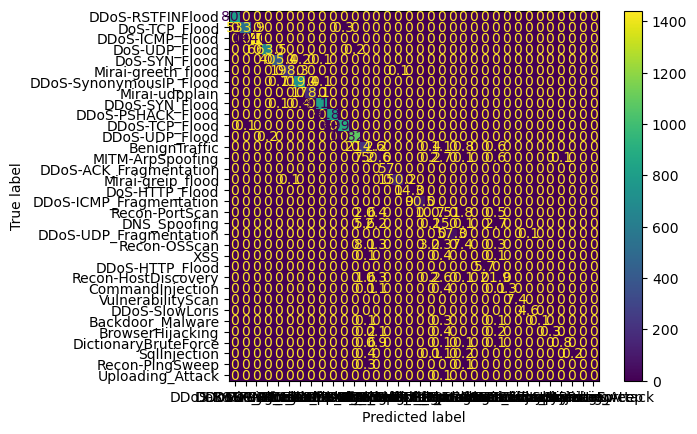

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 1d 19h 21min 46s, sys: 14min 37s, total: 1d 19h 36min 24s
Wall time: 57min 42s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9947360676237155),
                ('Precision (Macro)', 0.840593879079319),
                ('Precision (Micro)', 0.9947360676237155),
                ('Precision (Weighted)', 0.9952472523707717),
                ('Recall (Macro)', 0.8810394147993517),
                ('Recall (Micro)', 0.9947360676237155),
                ('Recall (Weighted)', 0.9947360676237155),
                ('F1 (Macro)', 0.8572501890035388),
                ('F1 (Micro)', 0.9947360676237155),
                ('F1 (Weighted)', 0.9949243709691338)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999985  0.999941  0.999963    809057
          DoS-TCP_Flood   0.999850  0.999861  0.999856    534289
        DDoS-ICMP_Flood   0.999984  0.999979  0.999982   1440101
          DoS-UDP_Flood   0.999792  0.999644  0.999718    663719
          DoS-SYN_Flood   0.999650  0.999776  0.999713    405767
     Mirai-greeth_flood   0.998624  0.998432  0.998528    198373
DDoS-SynonymousIP_Flood   0.999947  0.999830  0.999889    719628
         Mirai-udpplain   0.999955  0.999876  0.999916    178115
         DDoS-SYN_Flood   0.999890  0.999836  0.999863    811838
      DDoS-PSHACK_Flood   0.999993  0.999940  0.999966    818951
         DDoS-TCP_Flood   0.999907  0.999904  0.999906    899533
         DDoS-UDP_Flood   0.999800  0.999857  0.999829   1082457
          BenignTraffic   0.967064  0.915461  0.940555    219639
       MITM-ArpSpoofing   0.914545  0.863554  0.888319     61519
 DDoS-ACK_Fragmentation 

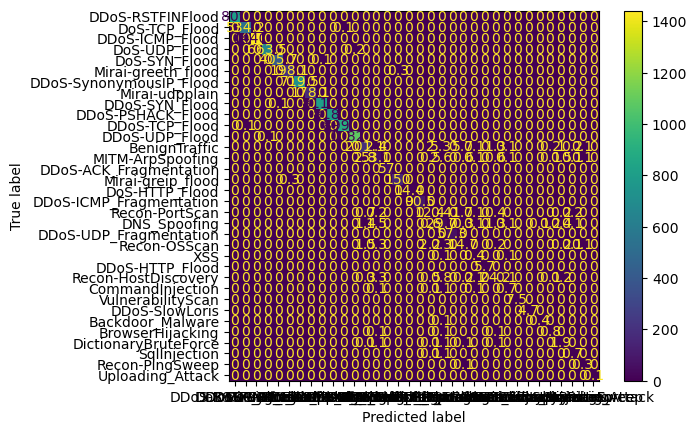

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)